# Graph Database Benchmark, Database Loading Results

In [1]:
# Common initialisation
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Datasets

As explained in the README TODO, we tested 3 datasets, of varying sizes, as defined below. For each dataset, we started from an initial RDF/Turtle file, which was generated with the Knetminer RDF Exporter TODO, starting from the knowledge graph XML files (or own OXL schema) that we generate for the Knetminer infrastructure.
  

In [2]:
datasets = [ "biopax", "ara", "poaceae" ]

The sizes of these datasets, in RDF triples, are:

In [3]:
triples = [ 
  1894700, # Biopax
  21354351, # Ara
  96537034 # Poaceae
]

## Loading Sequence
For each database type, and for each dataset, the loading procedure was always the same:
1. We used the same server host, with the features: **TODO**
1. Before loading, we stopped any other relevant service on the server and started the target database only
  1. For each new dataset, we cleaned the DB to its initial, empty configuration, eg, we deleted the DB server's data directory
1. In other words, we tested one database at a time and one dataset at a time
1. In these conditions, we timed the loading and related operations described below. Tools like rdf2pg tools were run on the same server host. This test things in the minimal resources scenario, with minimal network latency.

## Loading into Virtuoso
In the case of Virtuoso, we just loaded the input file for each dataset into the triple store. We have used a simple utility script of our own for doing so, which doesn't have any impact on its performance. These are the loading times for each dataset, in seconds:

In [4]:
virtuoso_load = [
  14.415, # BioPax
  153.925, # Ara
  681.03 # Poaceae
]
    

Virtuoso automatically indexes the triples it creates (eg, to efficiently match <s, p, *> patterns) and the times above include the time spent into making such indexes (since it is difficult to extract them from the Virtuoso logs).


## Generating the TDB triple store for rdf2pg tools

As explained in the documentation, both the rdf2neo and rdf2graphml tools require that input RDF files are first loaded into a local Jena TDB triple store, or that an already existing TDB (eg, one that was populated in a previous run) is given to either tool.

For each dataset, we have done the TDB creation step during the rdf2neo execution tool, we have passed the same TDB generated at this step to the rdf2graphml tool. This is motivated by the fact that this preliminary TDB creation is based on exactly the same code for both tools (in general, for any PG endpoint based on the rdf2pg framework).

We obtained these loading times for that:

In [5]:
tdb_load = [
  24.42, # Biopax
  264.974, # Ara
  1936.27 # Poaceae
]

## Property Graph Sizes
For sake of completness, rdf2neo and rdf2graphml generated graphs having the following sizes:

In [6]:
pg_sizes = {
  "Nodes": [ 173704, 898075, 3381073 ],
  "Relations": [ 527615, 3486599, 13920760 ]
}
pd.DataFrame ( index = datasets, data = pg_sizes )

,Nodes,Relations
biopax,173704,527615
ara,898075,3486599
poaceae,3381073,13920760


Both the tools generate the same PG graph, just represented in different ways, so the numbers above apply to all of the Neo4j, graphML files and ArcadeDB targets that we tested.

## Populating Neo4j
The rdf2neo tool first populates a Neo4j from its TDB input (we always started from an empty DB). Then it takes some time to extract the elements that have to be indexed from the TDB (eg, pairs of node/edge names and properties to be indexed for a type, the rdf2pg tools get those elements via SPARQL, see TODO). The total Neo4j loading time is a sum of these two: 

In [7]:
neo_db_load = pd.Series ( [ 38.919, 338, 1445] )
neo_idx = pd.Series ( [ 2.513, 67, 420 ] )
neo_load = neo_db_load + neo_idx
neo_load.index = datasets
neo_load

biopax       41.432
ara         405.000
poaceae    1865.000
dtype: float64

## Populating ArcadeDB
In order to populate ArcadeDB with the same PG graph that we used for Neo4j, we first used the rdf2graphml tool to generate a graphML representation of such graph. Here the times to generate the graphML output:

In [8]:
# As above, biopax, ara, poaceae
graphml = [ 7.178, 331, 1422]

The graphML file was loaded int ArcadeDB, using Gremlin helpers, obtaining these times:

In [9]:
arcade_load = [ 17.376, 135.547, 649.051 ]

The tool runs the same index-related SPARQL queries that is used for rdf2neo, however it uses the results to generate a table of type/property pairs to index:

In [10]:
arcade_tsv = [ 0, 71, 419 ]

This table is used with a Python script TODO, which spawns ArcadeDB SQL instructions to actually produce the indexes in the database. Because that script requires a list of all available node labels and all available edge types, we tracked the times to get them too (despite they're very small):

In [11]:
arcade_list_labels = [ 0.081, 0.08, 0.08 ]
arcade_list_edge_types = [ 0.098, 0.072, 0.08 ]
arcade_idx_sql_gen = [ 0.029, 0.029, 0.029 ]

Finally, we tracked the time to execute the indexing SQL, and we got a total for indexing:

In [12]:
arcade_idx_sql_exec = [5.818, 55.666, 35]

arcade_idx = pd.Series ( np.zeros ( shape = len ( datasets ) ) )
for a in [ arcade_tsv, arcade_list_labels, arcade_list_edge_types, arcade_idx_sql_gen, arcade_idx_sql_exec ]:
  arcade_idx = arcade_idx + pd.Series ( a )
arcade_idx

0      6.026
1    126.847
2    454.189
dtype: float64

We consider the total loading times the sum of database population times and all indexing-related times:

In [13]:
arcade_loading = pd.Series ( arcade_load ) + arcade_idx
arcade_loading.index = datasets
arcade_loading

biopax       23.402
ara         262.394
poaceae    1103.240
dtype: float64

Note that we represent the graphML generation separately, since summing it isn't strictly related to ArcadeDB itself and adding this time to the DB population time wouldn't yield values that are comparable with the corresponding loading times for Neo4j.

## Comparing Loading Times
Let's put together some of the loading times above and compare them:

In [14]:
load_stats = {
  "Triples": triples,
  "Virtuoso": virtuoso_load,
  "TDB": tdb_load,
  "Neo4j": neo_load,
  "graphML": graphml,
  "ArcadeDB": arcade_loading
}
load_stats = pd.DataFrame ( data = load_stats, index = datasets )
load_stats.index.name = "Dataset"
load_stats

,Triples,Virtuoso,TDB,Neo4j,graphML,ArcadeDB
Dataset,,,,,,
biopax,1894700,14.415,24.420,41.432,7.178,23.402
ara,21354351,153.925,264.974,405.000,331.000,262.394
poaceae,96537034,681.030,1936.270,1865.000,1422.000,1103.240


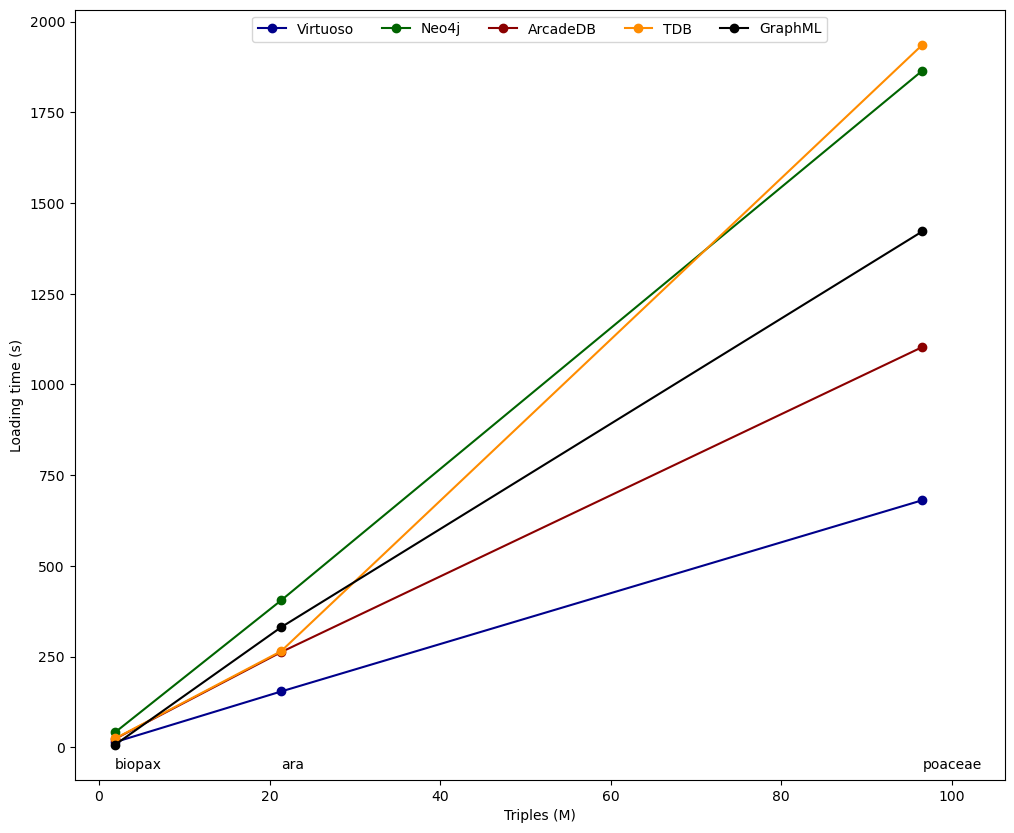

In [15]:
g_load_stats = load_stats.copy ()
g_load_stats [ "Triples" ] = load_stats [ "Triples" ] / 1E6 # Show thousands
mrk = "o"

ax = g_load_stats.plot ( 
  x = "Triples", y = "Virtuoso", label = "Virtuoso", color = "DarkBlue", marker = mrk )
ax = g_load_stats.plot ( 
  x = 'Triples', y = "Neo4j", label = "Neo4j", color = "DarkGreen", marker = mrk, ax = ax
);
ax = g_load_stats.plot ( 
  x = 'Triples', y = "ArcadeDB", label = "ArcadeDB", color = "DarkRed", marker = mrk, ax = ax, legend = True
);
ax = g_load_stats.plot ( 
  x = 'Triples', y = "TDB", label = "TDB", color = "DarkOrange", ax = ax, marker = mrk
);
ax = g_load_stats.plot ( 
  x = 'Triples', y = "graphML", label = "GraphML", color = "Black", marker = mrk, ax = ax
);


ax.set_xlabel ( "Triples (M)" )
ax.set_ylabel ( "Loading time (s)" )
ax.legend ( loc = "upper center", ncol=len ( load_stats.columns ) );

# Datapoint labels
for ids in range ( len ( datasets ) ):
  x = g_load_stats [ "Triples" ].iloc [ ids ]
  y = -60
  l = datasets [ ids ]
  ax.text ( x, y, l )
# Fit the last label
xmax = g_load_stats [ "Triples" ].iloc [ -1 ]
ax.set_xlim ( xmax = xmax * 1.1 )

# Give it a good size
ax.figure.set_size_inches ( 12, 10 )

# And save!
img_fmt = "svg"
ax.figure.savefig ( "loading-results." + img_fmt, format = img_fmt )

Some conclusion notes:
* Everything scales linearly
* Loading times are reasonable (about 30min for 100M triples)
* PG conversion obviusly has its own overhead, due to executing SPARQL mapping queries (against TDB) and further steps to create the target PG
* Neo4j and ArcadeDB have not too much different loading times. ArcadeDB loading could be faster with a specific loader that talks to the DB directly (without the graphML step). However, this isn't within the scope of this work.